# Import Dependancies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

connection_string = f"group5:Group5Project@nbastats2.c4lr0vlcqzd5.us-east-1.rds.amazonaws.com:5432/NBA_Stats"
engine = create_engine(f'postgresql://{connection_string}')


In [3]:
# Read the csv file into a pandas DataFrame

all_rookies_df = pd.read_excel('Data/ROY Data/all_rookies_1990_2020_save.xlsx')
all_rookies_df.drop(columns=['Unnamed: 0','Rk','Debut','Age','Yrs'],inplace=True)
all_rookies_df["Player"] = all_rookies_df.Player.str.replace('*', '')

# Create a dataframe of rookies for the 2019-20
rookies_2019_20_df = all_rookies_df.loc[all_rookies_df["season"] == "2019-20"]

# Remove records for the 2019-20 season from all rookies dataframe
all_rookies_df = all_rookies_df.loc[all_rookies_df["season"] != "2019-20"]


In [4]:
# Read Rookie of the Year candidates from csv
roy_votes_df = pd.read_excel('Data/ROY Data/all_roy_candidates_1990_2020.xlsx')

# Restructure the dataframe to contain only player and season
roy_votes_df = roy_votes_df[["Player", "season"]]

# Add a column and set to 1 as Rookie of the Year candidate
roy_votes_df["ROYCandidate"] = 1
#roy_votes_df

In [5]:
# Set NaN to 0
rookies_2019_20_df["3P%"] = rookies_2019_20_df["3P%"].fillna(0)
rookies_2019_20_df["FG%"] = rookies_2019_20_df["FG%"].fillna(0)

# Add additional per game average columns
rookies_2019_20_df["BLKPG"] = rookies_2019_20_df["BLK"]/rookies_2019_20_df["G"]
rookies_2019_20_df["STLPG"] = rookies_2019_20_df["STL"]/rookies_2019_20_df["G"]
rookies_2019_20_df["TOVPG"] = rookies_2019_20_df["TOV"]/rookies_2019_20_df["G"]


In [6]:
# left merge all rookies and candidates
all_rookies_df = pd.merge(all_rookies_df, roy_votes_df, how='left', on=["Player","season"])

# Set all ROYCandidate to 0 if it is Nan - Not a candidate
all_rookies_df["ROYCandidate"] = all_rookies_df["ROYCandidate"].fillna(0)
all_rookies_df["3P%"] = all_rookies_df["3P%"].fillna(0)
all_rookies_df["FG%"] = all_rookies_df["FG%"].fillna(0)

all_rookies_df["BLKPG"] = all_rookies_df["BLK"]/all_rookies_df["G"]
all_rookies_df["STLPG"] = all_rookies_df["STL"]/all_rookies_df["G"]
all_rookies_df["TOVPG"] = all_rookies_df["TOV"]/all_rookies_df["G"]



In [7]:
# Read csv file with advnaced statistics
advanced_df = pd.read_csv("AdvancedStats.csv")

# drop column player as it is not needed
advanced_df.drop(columns="Player", inplace=True)
# rename PlayerName to Player to make merge easier
advanced_df["Player"] = advanced_df["PlayerName"]

# Drop duplicate records for players played on multiple teams during a season, keep the Totals
advanced_df = advanced_df.drop_duplicates(subset=['Player','season'], keep='first')
#advanced_df = advanced_df.loc[advanced_df["Tm"] != "TOT"]

# Merge All Rookies and Advanced Statistics
all_rookies_df = pd.merge(all_rookies_df, advanced_df, how='inner', on=["Player","season"])

# Set values to 0 for NaN
all_rookies_df["PER"] = all_rookies_df["PER"].fillna(0)
all_rookies_df["WS"] = all_rookies_df["WS"].fillna(0)
all_rookies_df["VORP"] = all_rookies_df["VORP"].fillna(0)

# Merge 2019-20 Rookies and Adbanced Statistics
rookies_2019_20_df = pd.merge(rookies_2019_20_df, advanced_df, how='inner', on=["Player","season"])

# Set values to 0 for NaN
rookies_2019_20_df["PER"] = rookies_2019_20_df["PER"].fillna(0)
rookies_2019_20_df["WS"] = rookies_2019_20_df["WS"].fillna(0)
rookies_2019_20_df["VORP"] = rookies_2019_20_df["VORP"].fillna(0)

In [8]:
all_rookies_df.columns


Index(['Player', 'G_x', 'MP_x', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '3P%', 'FT%',
       'MP.1', 'PTS.1', 'TRB.1', 'AST.1', 'season', 'ROYCandidate', 'BLKPG',
       'STLPG', 'TOVPG', 'Rk', 'Pos', 'Age', 'Tm', 'G_y', 'MP_y', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'PlayerName', 'PlayerID'],
      dtype='object')

# Data Pre-processing

Includes:

* Converting categorical data
* Feature selection
* Scaling and transforming data

In [9]:
# Assign X (features) and y (target)
# X and y to be used for trin/test
# Xr is current rookies to predict if Rookie of the year candidate

X = all_rookies_df[['MP.1','PER','WS','VORP']]
Xr = rookies_2019_20_df[['MP.1','PER','WS','VORP']]

#X = all_rookies_df[['MP.1', 'PTS.1', 'TRB.1', 'AST.1','BLKPG','STLPG']]
#Xr = rookies_2019_20_df[['MP.1', 'PTS.1', 'TRB.1', 'AST.1','BLKPG','STLPG']]
y = all_rookies_df["ROYCandidate"]

# Reshape target if necessary (some functions in sklearn require 2-d arrays)
y = y.values.reshape(-1, 1)

In [10]:
# Split the data into training and testing
# Default split is 80% testing, 20% training
# Setting random_state is not necessary but makes results reproducible

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
# Create a StandardScater model and fit it to the training data
# StandardScaler makes data normally distributed

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [12]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
Xr_test_scaled = X_scaler.transform(Xr)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Create and test model(s)

## Create and Fit Model

Includes:
* Instantiating model
* Fitting with or without hyperparameter tuning (including GridsearchCV)

In [13]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, encoded_y_train)

print(f"Training Data Score: {rf.score(X_train_scaled, encoded_y_train)}")
print(f"Testing Data Score: {rf.score(X_test_scaled, encoded_y_test)}")

C:\Users\nickv\Anaconda3\envs\PythonAdvanced2\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Training Data Score: 1.0
Testing Data Score: 0.9238095238095239


In [14]:
from sklearn.svm import SVC 

from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [400, 700, 1000]
}
grid2 = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=3)

grid2.fit(X_train_scaled, encoded_y_train)

print(grid2.best_params_)
print(grid2.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=400 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=400, score=0.946, total=   0.9s
[CV] n_estimators=400 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .................... n_estimators=400, score=0.943, total=   1.0s
[CV] n_estimators=400 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] .................... n_estimators=400, score=0.940, total=   0.9s
[CV] n_estimators=400 ................................................
[CV] .................... n_estimators=400, score=0.927, total=   0.9s
[CV] n_estimators=400 ................................................
[CV] .................... n_estimators=400, score=0.949, total=   0.9s
[CV] n_estimators=700 ................................................
[CV] .................... n_estimators=700, score=0.946, total=   1.6s
[CV] n_estimators=700 ................................................
[CV] .................... n_estimators=700, score=0.946, total=   1.6s
[CV] n_estimators=700 ................................................
[CV] .................... n_estimators=700, score=0.930, total=   1.7s
[CV] n_estimators=700 ................................................
[CV] .................... n_estimators=700, score=0.927, total=   1.6s
[CV] n_estimators=700 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   25.0s finished


{'n_estimators': 400}
0.9408735213830756


In [15]:
predictions2 = grid2.predict(X_test_scaled)
predictions = grid2.predict(Xr_test_scaled)

from sklearn.metrics import classification_report
print(classification_report(encoded_y_test, predictions2,
                           target_names=["Not ROY Candidate", "ROY Candidate"]))

                   precision    recall  f1-score   support

Not ROY Candidate       0.94      0.98      0.96       471
    ROY Candidate       0.75      0.44      0.56        54

         accuracy                           0.93       525
        macro avg       0.84      0.71      0.76       525
     weighted avg       0.92      0.93      0.92       525



In [16]:
name_list = []
season_list = []
team_list = []
model_list = []

for i in range(len(predictions)):
    if predictions[i] == 1:
        print(i,rookies_2019_20_df.iloc[i,0],rookies_2019_20_df.iloc[i,31],rookies_2019_20_df.iloc[i,24])
        name_list.append(rookies_2019_20_df.iloc[i,0])
        season_list.append(rookies_2019_20_df.iloc[i,24])
        team_list.append(rookies_2019_20_df.iloc[i,31])
        model_list.append("Basic Stats Random Forest")

16 Brandon Clarke MEM 2019-20


In [17]:
from sklearn.neighbors import KNeighborsClassifier
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, encoded_y_train)
    train_score = knn.score(X_train_scaled, encoded_y_train)
    test_score = knn.score(X_test_scaled, encoded_y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, encoded_y_train)
print('Test Acc: %.3f' % knn.score(X_test_scaled, encoded_y_test))
print(f"Training Data Score: {knn.score(X_train_scaled, encoded_y_train)}")
print(f"Testing Data Score: {knn.score(X_test_scaled, encoded_y_test)}")



k: 1, Train/Test Score: 1.000/0.916
k: 3, Train/Test Score: 0.963/0.928
k: 5, Train/Test Score: 0.956/0.928
k: 7, Train/Test Score: 0.949/0.933
k: 9, Train/Test Score: 0.950/0.935
k: 11, Train/Test Score: 0.949/0.935
k: 13, Train/Test Score: 0.950/0.933
k: 15, Train/Test Score: 0.953/0.931
k: 17, Train/Test Score: 0.950/0.933
k: 19, Train/Test Score: 0.949/0.930
Test Acc: 0.935
Training Data Score: 0.9504132231404959
Testing Data Score: 0.9352380952380952


In [18]:
predictions2 = knn.predict(X_test_scaled)
predictions = knn.predict(Xr_test_scaled)

from sklearn.metrics import classification_report
print(classification_report(encoded_y_test, predictions2,target_names=["Not ROY Candidate", "ROY Candidate"]))


                   precision    recall  f1-score   support

Not ROY Candidate       0.94      0.99      0.96       471
    ROY Candidate       0.81      0.48      0.60        54

         accuracy                           0.94       525
        macro avg       0.88      0.73      0.78       525
     weighted avg       0.93      0.94      0.93       525



In [19]:
for i in range(len(predictions)):
    if predictions[i] == 1:
        print(i,rookies_2019_20_df.iloc[i,0],rookies_2019_20_df.iloc[i,31],rookies_2019_20_df.iloc[i,24])
        name_list.append(rookies_2019_20_df.iloc[i,0])
        season_list.append(rookies_2019_20_df.iloc[i,24])
        team_list.append(rookies_2019_20_df.iloc[i,31])
        model_list.append("Basic Stats KNN")

35 Rui Hachimura WAS 2019-20


In [20]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

deep_model = Sequential()
deep_model.add(Dense(units=8, activation='relu', input_dim=4))
deep_model.add(Dense(units=8, activation='relu'))
deep_model.add(Dense(units=2, activation='softmax'))

deep_model.summary()

deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)


model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled,y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________
Train on 1573 samples
Epoch 1/1000
1573/1573 - 1s - loss: 0.6744 - accuracy: 0.5391
Epoch 2/1000
1573/1573 - 0s - loss: 0.4429 - accuracy: 0.9205
Epoch 3/1000
1573/1573 - 0s - loss: 0.2984 - accuracy: 0.9313
Epoch 4/1000
1573/1573 - 0s - loss: 0.2353 - accuracy: 0.9339
Epoch 5/1000
1573/1573 - 0s - loss: 0.2063 - accuracy: 0.9352
Epoch 6/1000
1573/1573 - 0s - loss: 0.1904 - accuracy: 0

Epoch 119/1000
1573/1573 - 0s - loss: 0.1213 - accuracy: 0.9479
Epoch 120/1000
1573/1573 - 0s - loss: 0.1208 - accuracy: 0.9485
Epoch 121/1000
1573/1573 - 0s - loss: 0.1212 - accuracy: 0.9479
Epoch 122/1000
1573/1573 - 0s - loss: 0.1210 - accuracy: 0.9479
Epoch 123/1000
1573/1573 - 0s - loss: 0.1210 - accuracy: 0.9472
Epoch 124/1000
1573/1573 - 0s - loss: 0.1209 - accuracy: 0.9472
Epoch 125/1000
1573/1573 - 0s - loss: 0.1211 - accuracy: 0.9485
Epoch 126/1000
1573/1573 - 0s - loss: 0.1207 - accuracy: 0.9466
Epoch 127/1000
1573/1573 - 0s - loss: 0.1209 - accuracy: 0.9491
Epoch 128/1000
1573/1573 - 0s - loss: 0.1210 - accuracy: 0.9479
Epoch 129/1000
1573/1573 - 0s - loss: 0.1208 - accuracy: 0.9472
Epoch 130/1000
1573/1573 - 0s - loss: 0.1211 - accuracy: 0.9472
Epoch 131/1000
1573/1573 - 0s - loss: 0.1210 - accuracy: 0.9485
Epoch 132/1000
1573/1573 - 0s - loss: 0.1205 - accuracy: 0.9485
Epoch 133/1000
1573/1573 - 0s - loss: 0.1204 - accuracy: 0.9479
Epoch 134/1000
1573/1573 - 0s - loss: 0.

1573/1573 - 0s - loss: 0.1147 - accuracy: 0.9504
Epoch 248/1000
1573/1573 - 0s - loss: 0.1144 - accuracy: 0.9504
Epoch 249/1000
1573/1573 - 0s - loss: 0.1145 - accuracy: 0.9498
Epoch 250/1000
1573/1573 - 0s - loss: 0.1143 - accuracy: 0.9485
Epoch 251/1000
1573/1573 - 0s - loss: 0.1140 - accuracy: 0.9504
Epoch 252/1000
1573/1573 - 0s - loss: 0.1144 - accuracy: 0.9485
Epoch 253/1000
1573/1573 - 0s - loss: 0.1144 - accuracy: 0.9479
Epoch 254/1000
1573/1573 - 0s - loss: 0.1141 - accuracy: 0.9491
Epoch 255/1000
1573/1573 - 0s - loss: 0.1141 - accuracy: 0.9504
Epoch 256/1000
1573/1573 - 0s - loss: 0.1142 - accuracy: 0.9479
Epoch 257/1000
1573/1573 - 0s - loss: 0.1143 - accuracy: 0.9504
Epoch 258/1000
1573/1573 - 0s - loss: 0.1141 - accuracy: 0.9479
Epoch 259/1000
1573/1573 - 0s - loss: 0.1141 - accuracy: 0.9498
Epoch 260/1000
1573/1573 - 0s - loss: 0.1144 - accuracy: 0.9498
Epoch 261/1000
1573/1573 - 0s - loss: 0.1141 - accuracy: 0.9485
Epoch 262/1000
1573/1573 - 0s - loss: 0.1137 - accuracy

Epoch 376/1000
1573/1573 - 0s - loss: 0.1114 - accuracy: 0.9466
Epoch 377/1000
1573/1573 - 0s - loss: 0.1122 - accuracy: 0.9498
Epoch 378/1000
1573/1573 - 0s - loss: 0.1115 - accuracy: 0.9491
Epoch 379/1000
1573/1573 - 0s - loss: 0.1112 - accuracy: 0.9479
Epoch 380/1000
1573/1573 - 0s - loss: 0.1116 - accuracy: 0.9491
Epoch 381/1000
1573/1573 - 0s - loss: 0.1117 - accuracy: 0.9479
Epoch 382/1000
1573/1573 - 0s - loss: 0.1116 - accuracy: 0.9517
Epoch 383/1000
1573/1573 - 0s - loss: 0.1128 - accuracy: 0.9479
Epoch 384/1000
1573/1573 - 0s - loss: 0.1112 - accuracy: 0.9504
Epoch 385/1000
1573/1573 - 0s - loss: 0.1113 - accuracy: 0.9479
Epoch 386/1000
1573/1573 - 0s - loss: 0.1116 - accuracy: 0.9472
Epoch 387/1000
1573/1573 - 0s - loss: 0.1118 - accuracy: 0.9504
Epoch 388/1000
1573/1573 - 0s - loss: 0.1115 - accuracy: 0.9479
Epoch 389/1000
1573/1573 - 0s - loss: 0.1113 - accuracy: 0.9472
Epoch 390/1000
1573/1573 - 0s - loss: 0.1114 - accuracy: 0.9466
Epoch 391/1000
1573/1573 - 0s - loss: 0.

Epoch 505/1000
1573/1573 - 0s - loss: 0.1096 - accuracy: 0.9510
Epoch 506/1000
1573/1573 - 0s - loss: 0.1099 - accuracy: 0.9485
Epoch 507/1000
1573/1573 - 0s - loss: 0.1095 - accuracy: 0.9491
Epoch 508/1000
1573/1573 - 0s - loss: 0.1099 - accuracy: 0.9479
Epoch 509/1000
1573/1573 - 0s - loss: 0.1094 - accuracy: 0.9491
Epoch 510/1000
1573/1573 - 0s - loss: 0.1096 - accuracy: 0.9510
Epoch 511/1000
1573/1573 - 0s - loss: 0.1092 - accuracy: 0.9504
Epoch 512/1000
1573/1573 - 0s - loss: 0.1095 - accuracy: 0.9504
Epoch 513/1000
1573/1573 - 0s - loss: 0.1093 - accuracy: 0.9491
Epoch 514/1000
1573/1573 - 0s - loss: 0.1095 - accuracy: 0.9504
Epoch 515/1000
1573/1573 - 0s - loss: 0.1094 - accuracy: 0.9510
Epoch 516/1000
1573/1573 - 0s - loss: 0.1092 - accuracy: 0.9523
Epoch 517/1000
1573/1573 - 0s - loss: 0.1091 - accuracy: 0.9504
Epoch 518/1000
1573/1573 - 0s - loss: 0.1093 - accuracy: 0.9498
Epoch 519/1000
1573/1573 - 0s - loss: 0.1092 - accuracy: 0.9504
Epoch 520/1000
1573/1573 - 0s - loss: 0.

Epoch 634/1000
1573/1573 - 0s - loss: 0.1083 - accuracy: 0.9517
Epoch 635/1000
1573/1573 - 0s - loss: 0.1080 - accuracy: 0.9530
Epoch 636/1000
1573/1573 - 0s - loss: 0.1081 - accuracy: 0.9517
Epoch 637/1000
1573/1573 - 0s - loss: 0.1080 - accuracy: 0.9498
Epoch 638/1000
1573/1573 - 0s - loss: 0.1081 - accuracy: 0.9504
Epoch 639/1000
1573/1573 - 0s - loss: 0.1081 - accuracy: 0.9523
Epoch 640/1000
1573/1573 - 0s - loss: 0.1084 - accuracy: 0.9510
Epoch 641/1000
1573/1573 - 0s - loss: 0.1081 - accuracy: 0.9523
Epoch 642/1000
1573/1573 - 0s - loss: 0.1076 - accuracy: 0.9517
Epoch 643/1000
1573/1573 - 0s - loss: 0.1085 - accuracy: 0.9479
Epoch 644/1000
1573/1573 - 0s - loss: 0.1087 - accuracy: 0.9504
Epoch 645/1000
1573/1573 - 0s - loss: 0.1082 - accuracy: 0.9530
Epoch 646/1000
1573/1573 - 0s - loss: 0.1087 - accuracy: 0.9485
Epoch 647/1000
1573/1573 - 0s - loss: 0.1081 - accuracy: 0.9523
Epoch 648/1000
1573/1573 - 0s - loss: 0.1080 - accuracy: 0.9523
Epoch 649/1000
1573/1573 - 0s - loss: 0.

1573/1573 - 0s - loss: 0.1073 - accuracy: 0.9510
Epoch 763/1000
1573/1573 - 0s - loss: 0.1067 - accuracy: 0.9517
Epoch 764/1000
1573/1573 - 0s - loss: 0.1077 - accuracy: 0.9530
Epoch 765/1000
1573/1573 - 0s - loss: 0.1074 - accuracy: 0.9523
Epoch 766/1000
1573/1573 - 0s - loss: 0.1070 - accuracy: 0.9517
Epoch 767/1000
1573/1573 - 0s - loss: 0.1069 - accuracy: 0.9510
Epoch 768/1000
1573/1573 - 0s - loss: 0.1080 - accuracy: 0.9498
Epoch 769/1000
1573/1573 - 0s - loss: 0.1070 - accuracy: 0.9485
Epoch 770/1000
1573/1573 - 0s - loss: 0.1069 - accuracy: 0.9498
Epoch 771/1000
1573/1573 - 0s - loss: 0.1072 - accuracy: 0.9510
Epoch 772/1000
1573/1573 - 0s - loss: 0.1072 - accuracy: 0.9536
Epoch 773/1000
1573/1573 - 0s - loss: 0.1074 - accuracy: 0.9530
Epoch 774/1000
1573/1573 - 0s - loss: 0.1079 - accuracy: 0.9485
Epoch 775/1000
1573/1573 - 0s - loss: 0.1071 - accuracy: 0.9523
Epoch 776/1000
1573/1573 - 0s - loss: 0.1069 - accuracy: 0.9530
Epoch 777/1000
1573/1573 - 0s - loss: 0.1069 - accuracy

Epoch 891/1000
1573/1573 - 0s - loss: 0.1057 - accuracy: 0.9510
Epoch 892/1000
1573/1573 - 0s - loss: 0.1058 - accuracy: 0.9517
Epoch 893/1000
1573/1573 - 0s - loss: 0.1055 - accuracy: 0.9523
Epoch 894/1000
1573/1573 - 0s - loss: 0.1055 - accuracy: 0.9523
Epoch 895/1000
1573/1573 - 0s - loss: 0.1055 - accuracy: 0.9523
Epoch 896/1000
1573/1573 - 0s - loss: 0.1061 - accuracy: 0.9530
Epoch 897/1000
1573/1573 - 0s - loss: 0.1064 - accuracy: 0.9498
Epoch 898/1000
1573/1573 - 0s - loss: 0.1057 - accuracy: 0.9530
Epoch 899/1000
1573/1573 - 0s - loss: 0.1055 - accuracy: 0.9530
Epoch 900/1000
1573/1573 - 0s - loss: 0.1060 - accuracy: 0.9523
Epoch 901/1000
1573/1573 - 0s - loss: 0.1056 - accuracy: 0.9523
Epoch 902/1000
1573/1573 - 0s - loss: 0.1061 - accuracy: 0.9536
Epoch 903/1000
1573/1573 - 0s - loss: 0.1054 - accuracy: 0.9504
Epoch 904/1000
1573/1573 - 0s - loss: 0.1057 - accuracy: 0.9510
Epoch 905/1000
1573/1573 - 0s - loss: 0.1059 - accuracy: 0.9536
Epoch 906/1000
1573/1573 - 0s - loss: 0.

In [22]:
# Load the model
from tensorflow.keras.models import load_model
deep_model = load_model("rookie_trained.h5")
#deep_model = load_model("rookie_trained_trad.h5")

ynew = deep_model.predict_classes(Xr_test_scaled)
for i in range(len(Xr_test_scaled)):
    if (ynew[i] == 1):
        print(i, rookies_2019_20_df.iloc[i,0],rookies_2019_20_df.iloc[i,31],rookies_2019_20_df.iloc[i,24])
        name_list.append(rookies_2019_20_df.iloc[i,0])
        season_list.append(rookies_2019_20_df.iloc[i,24])
        team_list.append(rookies_2019_20_df.iloc[i,31])
        model_list.append("Basic Stats Deep Learning")


16 Brandon Clarke MEM 2019-20
35 Rui Hachimura WAS 2019-20
39 Jaxson Hayes NOP 2019-20
72 Ja Morant MEM 2019-20
78 Kendrick Nunn MIA 2019-20
82 Eric Paschall GSW 2019-20
105 P.J. Washington CHO 2019-20
112 Zion Williamson NOP 2019-20


In [ ]:
# Save the model
#deep_model.save("rookie_trained_trad.h5")

In [ ]:
#df = pd.DataFrame({'Player': name_list, 'season': season_list, 'Tm': team_list, 'model': model_list})
#df.to_sql(name='roy_predictions', con=engine, if_exists='append', index=False)

In [23]:
imp = rf.feature_importances_
feature_list=[]
weight_list=[]
model_list=[]

for i,value in enumerate(imp):
    print(X.columns[i],value, "RF Advanced") 
    feature_list.append(X.columns[i])
    weight_list.append(value)
    model_list.append("RF Basic")

MP.1 0.3809258985608665 RF Advanced
PER 0.1578963186965494 RF Advanced
WS 0.24838465447085986 RF Advanced
VORP 0.2127931282717241 RF Advanced


In [24]:
from sklearn.inspection import permutation_importance
results = permutation_importance(knn,X_train_scaled, encoded_y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

sumImportances = 0.0
for v in importance:
    sumImportances += v
print(sumImportances)
# summarize feature importance
for i,v in enumerate(importance):
    print(X.columns[i], v/sumImportances, "KNN Basic")
    feature_list.append(X.columns[i])
    weight_list.append(v/sumImportances)
    model_list.append("KNN Advanced")    

0.05111252383979678
MP.1 0.3134328358208954 KNN Basic
PER 0.1393034825870653 KNN Basic
WS 0.1641791044776122 KNN Basic
VORP 0.38308457711442717 KNN Basic


In [ ]:
df = pd.DataFrame({'feature': feature_list, 'weight': weight_list, 'model': model_list})
#df.to_sql(name='roy_feature_weights', con=engine, if_exists='append', index=False)

<function matplotlib.pyplot.show(*args, **kw)>

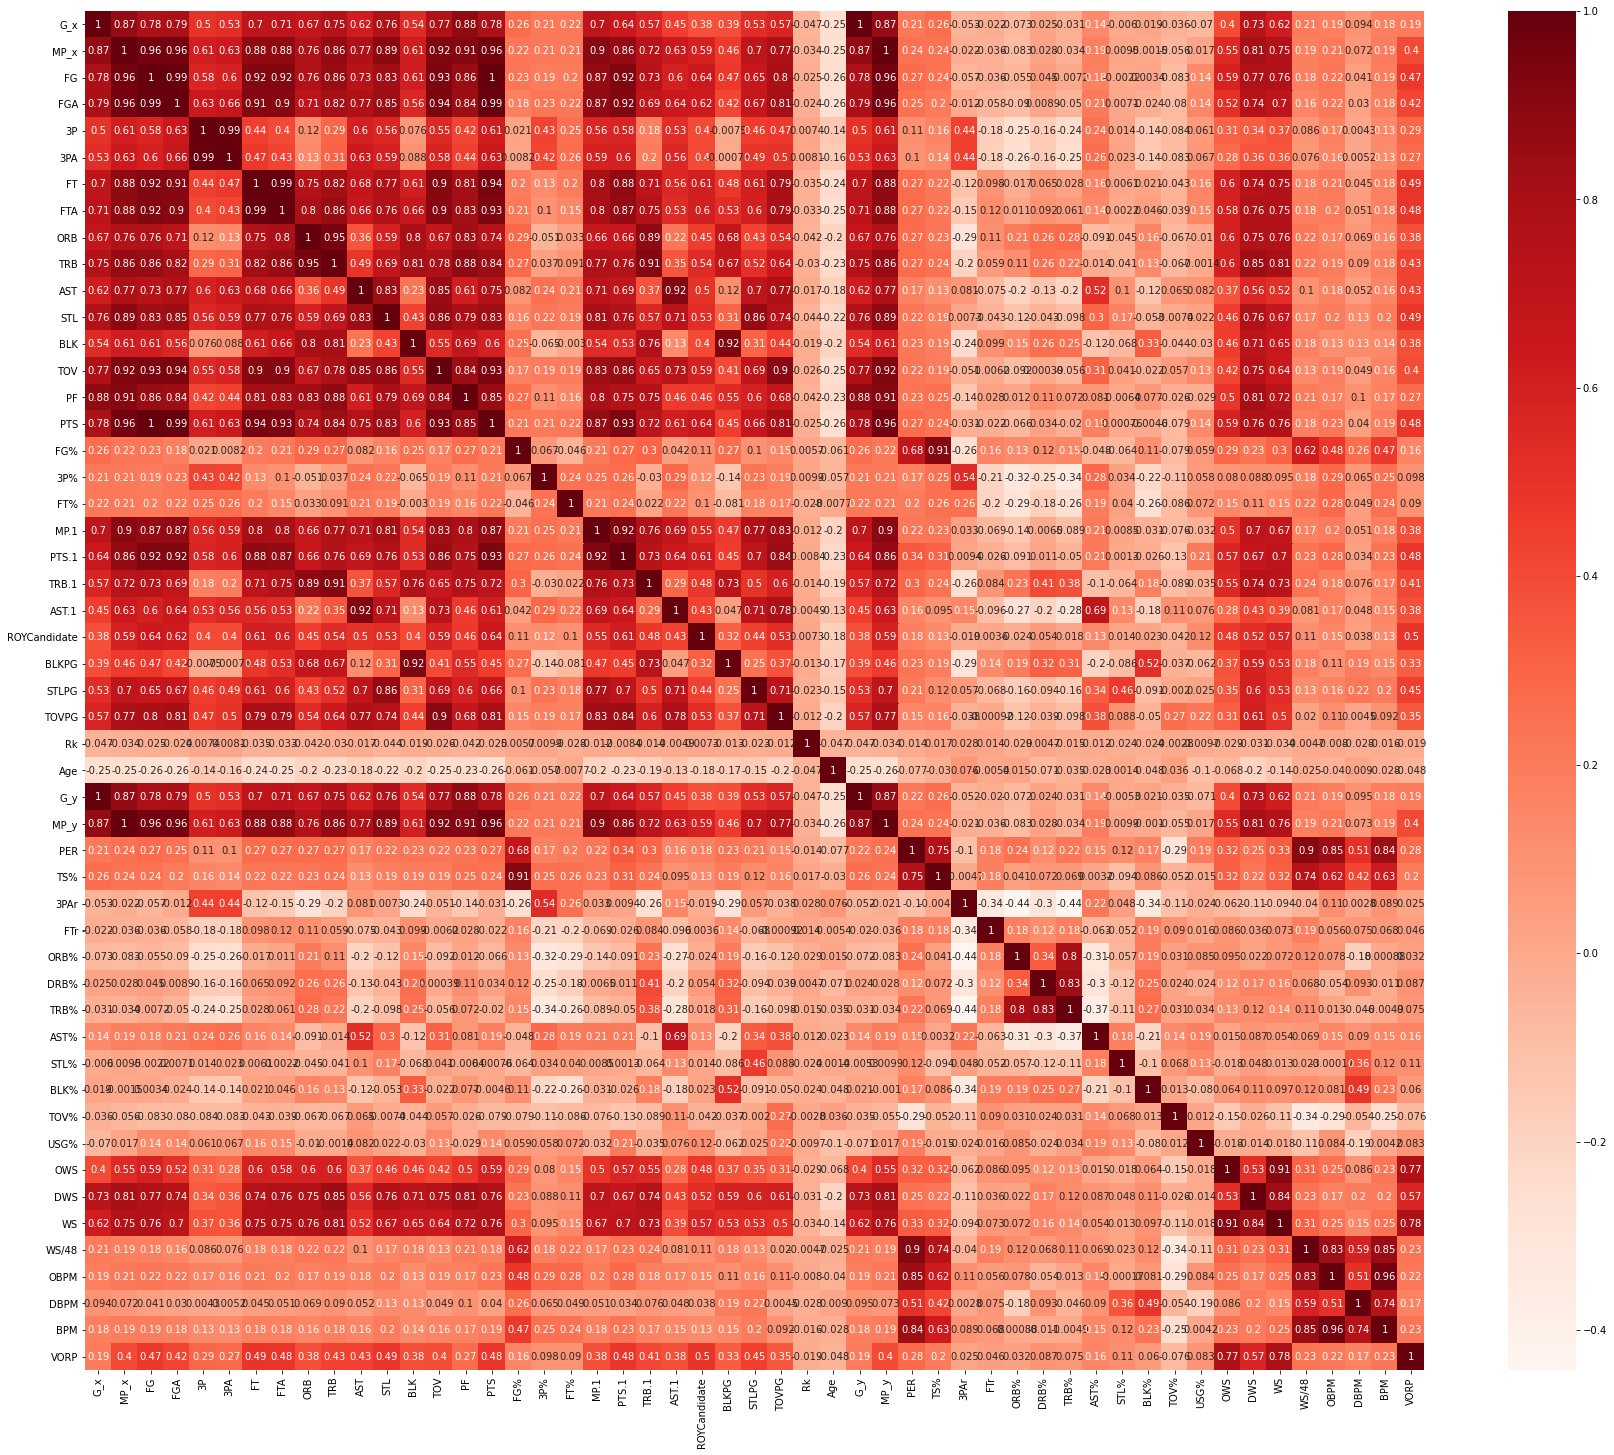

In [29]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.figure(figsize=(30,25))
cor = all_rookies_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show